## Demo of episode follower

### import and arguments

In [1]:
import glob
import argparse
import os 
from os import path as osp
import numpy as np
import tqdm
import matplotlib.pyplot as plt 
from habitat.utils.visualizations.utils import images_to_video
import habitat_sim
from PIL import Image 

# local import 
# cd to the root directory of this project 
%cd /home/junting/project_cvl/SceneGraphNav
from dataset.habitat.simulator import init_sim


# NUM_TESTS = 100
# TURN_DEGREE = 30.0
# ACCEPTABLE_SPLS = {
#     ("try_step", False): 0.97,
#     ("try_step_no_sliding", False): 0.925,
#     ("try_step", True): 0.82,
#     ("try_step_no_sliding", True): 0.60,
# }

scene_error = ['HxpKQynjfin', '29hnd4uzFmX']
scene_empty_map = ['fzynW3qQPVF']


def parse_args(input=""):

    parser = argparse.ArgumentParser()
    parser.add_argument("--scan_dir", type=str, default="/media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans")
    parser.add_argument("--task_dir", type=str, default="/media/junting/SSD_data/habitat_data/datasets/objectnav/mp3d/v1")
    parser.add_argument("--scene_name", type=str, default="HxpKQynjfin") # 17DRP5sb8fy
    parser.add_argument("--dataset", type=str, default="matterport")
    # parser.add_argument("--split")

    parser.add_argument("--visualize", type=int, default=1)
    parser.add_argument("--vis_mode", type=str, default="segment", choices=["rgb", "segment"])
    
    parser.add_argument("--rel_dist_thresh", type=float, default=2.0, help="threshold of max distance between two objects that could have a relationship")

    args = parser.parse_args(input)  
    args.scene_ply_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_semantic.ply')
    args.scene_glb_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.glb')
    args.pclseg_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_pclseg.txt')
    args.pcl_normals_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_normals.npy')
    args.house_file_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.house')
    args.navmesh_file_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.navmesh')
    if os.path.exists(
        os.path.join(args.task_dir, 'train', 'content', f'{args.scene_name}.json.gz')
    ): # train split 
        args.episode_path = os.path.join(args.task_dir, 'train', 'content', f'{args.scene_name}.json.gz') 
        print(f"scene {args.scene_name} is in train split")
    elif os.path.exists(
        os.path.join(args.task_dir, 'val', 'content', f'{args.scene_name}.json.gz')
    ): # val split 
        args.episode_path = os.path.join(args.task_dir, 'val', 'content', f'{args.scene_name}.json.gz') 
        print(f"scene {args.scene_name} is in val split")
    else:
        print(f"No episode file found for scene {args.scene_name}")
        args.episode_path = None
    
    return args 

args = parse_args()


/home/junting/project_cvl/SceneGraphNav
scene HxpKQynjfin is in train split


### util functions 

In [2]:

def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)
    
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

### initialize habitat environment 

In [ ]:
# sim, action_names, sim_settings = init_sim(args.scene_glb_path)
# seed = 0
# np.random.seed(seed=seed)
# sim.pathfinder.seed(seed)

# greedy_follower = sim.make_greedy_follower() # use all default settings of simulator 

In [4]:
pathfinder = habitat_sim.PathFinder()
pathfinder.load_nav_mesh(args.navmesh_file_path)
assert pathfinder.is_loaded
pathfinder.seed(0)
np.random.seed(seed=0)

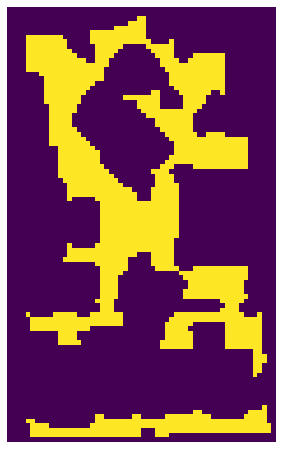

In [6]:
top_down_map = pathfinder.get_topdown_view(0.1, 0)
display_map(top_down_map)

### load ground truth episode 

dict_keys(['goals_by_category', 'episodes', 'category_to_task_category_id', 'category_to_mp3d_category_id'])
Load 47500 number of episodes


### main 

In [ ]:

ep_idx = 0
episode = 
test_spl = 0.0

